# Speech-to-Text Application for Accessibility

**Aim:** Build a Python-based speech-to-text system (real-time / file-based) that:

- Records or accepts audio files,
- Transcribes using *at least two methods* (offline + online),
- Provides clear user feedback at every stage,
- Handles errors gracefully,
- Produces a comparative table and short inference.

**Methods included in this notebook**
- **Offline**: OpenAI Whisper (`whisper` package)
- **Offline**: Vosk (`vosk` package)
- **Online**: Google Web Speech API (via `SpeechRecognition`) — requires internet

> This notebook is designed to run in **Google Colab**. It contains step-by-step explanations and code cells that you can run sequentially. Each code cell prints user-friendly messages like **"Speak something..."**, **"Recognizing..."**, and **"Speech successfully converted to text!"**.

**How to use**
1. Upload your audio files, or mount Google Drive and use the provided Drive link.
2. Record audio directly inside Colab using the _Record_ cell.
3. Run the preprocessing cell to convert audio to WAV 16 kHz mono.
4. Run the transcribers (Whisper, Vosk, Google) and compare outputs.
5. Fill the comparison table for different audio types (clear male, clear female, fast, noisy, soft).

---


In [7]:
!apt-get update -qq
!apt-get install -y -qq ffmpeg libsndfile1

!pip install -q --upgrade pip
!pip install -q openai-whisper
!pip install -q vosk
!pip install -q SpeechRecognition pydub soundfile
!pip install -q jiwer
!pip install sounddevice

print('Dependencies installed. Next: Mount Drive / Upload or Record audio.')


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'srt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'srt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
Dependencies installed. Next: Mount Drive / Upload or Record audio.


## 1) Get audio into the notebook

Record directly inside Colab using your microphone


###Record audio inside Colab (browser microphone)

Run the record cell; it will:
- Ask for microphone permissions in your browser,
- Record for the specified number of seconds,
- Save the file as `recorded.wav`.

**User messages**:
- Before recording: `Speak something...`
- During recording: the browser will be capturing audio
- After recording: file saved as `recorded.wav`


In [4]:
from IPython.display import Javascript, display
from base64 import b64decode
from google.colab import output

def _save_audio(base64_audio, filename='recorded.wav'):
    header, encoded = base64_audio.split(',', 1)
    data = b64decode(encoded)
    with open(filename, 'wb') as f:
        f.write(data)
    print(f'Audio saved to {filename}')

output.register_callback('notebook.save_audio', _save_audio)

print('Speak something... (the browser will record for 10 seconds)')
display(Javascript(r'''
const sleep = t => new Promise(res => setTimeout(res, t));
async function record(duration, filename) {
  const stream = await navigator.mediaDevices.getUserMedia({audio: true});
  const mediaRecorder = new MediaRecorder(stream);
  let chunks = [];
  mediaRecorder.ondataavailable = e => chunks.push(e.data);
  mediaRecorder.start();
  await sleep(duration * 1000);
  mediaRecorder.stop();
  await sleep(500);
  const blob = new Blob(chunks);
  const reader = new FileReader();
  reader.readAsDataURL(blob);
  reader.onloadend = () => {
    const base64data = reader.result;
    google.colab.kernel.invokeFunction('notebook.save_audio', [base64data, filename], {});
  };
}
record(10, 'recorded.wav');
'''))

Speak something... (the browser will record for 10 seconds)


<IPython.core.display.Javascript object>

Audio saved to recorded.wav


## 2) Preprocess audio (convert to WAV 16 kHz mono)

We normalize audio to a single, consistent format (16 kHz, mono, PCM 16-bit). This helps offline recognizers like Vosk and Whisper deliver consistent results.


In [5]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)
from pydub import AudioSegment
import os

def convert_to_wav_16k_mono(src_path, dst_path=None):
    if dst_path is None:
        base, _ = os.path.splitext(src_path)
        dst_path = base + '_16k_mono.wav'
    audio = AudioSegment.from_file(src_path)
    audio = audio.set_frame_rate(16000).set_channels(1).set_sample_width(2)
    audio.export(dst_path, format='wav')
    return dst_path

print('Run convert_to_wav_16k_mono(src_path) with your source file path.')


Run convert_to_wav_16k_mono(src_path) with your source file path.


## 3) Offline transcription — Whisper

We use Whisper (open-source) for offline transcription. Whisper offers multiple model sizes — `tiny`, `base`, `small`, `medium`, `large`. Larger models are more accurate but slower and heavier.

**User feedback**:
- Before: `Recognizing...`
- On success: `Speech successfully converted to text!`


In [8]:
import whisper
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

print("Recognizing with Whisper...")
model = whisper.load_model("base")
result = model.transcribe("recorded.wav")
print("Speech recognized:", result["text"])
print("Speech successfully converted to text!")


Recognizing with Whisper...


100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 31.9MiB/s]


Speech recognized:  Hello my name is Mahik and I am starting in 5 MSI
Speech successfully converted to text!


## 4) Offline transcription — Vosk

Vosk requires a model downloaded locally (small English models are available). For Colab, download a lightweight model and point `vosk.Model()` to its folder.


In [9]:
from vosk import Model, KaldiRecognizer
import wave, json

normalized_file = convert_to_wav_16k_mono("recorded.wav")

print("Recognizing with Vosk...")
wf = wave.open(normalized_file, "rb")

vosk_model = Model(lang="en-us")
rec = KaldiRecognizer(vosk_model, wf.getframerate())

vosk_text = ""
while True:
    data = wf.readframes(4000)
    if len(data) == 0:
        break
    if rec.AcceptWaveform(data):
        res = json.loads(rec.Result())
        vosk_text += res.get("text", "") + " "
res = json.loads(rec.FinalResult())
vosk_text += res.get("text", "")

print("Speech recognized:", vosk_text.strip())
print("Speech successfully converted to text with Vosk!")

Recognizing with Vosk...


vosk-model-small-en-us-0.15.zip: 100%|██████████| 39.3M/39.3M [00:03<00:00, 10.4MB/s]


Speech recognized: hello my name is my heck and i am turning in five and with yeah man
Speech successfully converted to text with Vosk!


## 5) Online transcription — Google Web Speech (via SpeechRecognition)

This uses the free Google Web Speech API via the `SpeechRecognition` library. It's convenient but **rate-limited** and requires internet.


In [10]:
normalized_file = convert_to_wav_16k_mono("recorded.wav")

import speech_recognition as sr

recognizer = sr.Recognizer()
with sr.AudioFile(normalized_file) as source:  # use the converted file
    print("Recognizing with Google API...")
    audio_data = recognizer.record(source)

    try:
        google_text = recognizer.recognize_google(audio_data)
        print("Speech recognized:", google_text)
        print("Speech successfully converted to text with Google API!")
    except sr.UnknownValueError:
        print("Speech Recognition could not understand audio. Please try speaking more clearly.")
    except sr.RequestError:
        print("Google API is unavailable. Please check your internet connection.")

Recognizing with Google API...
Speech recognized: hello my name is mehak and I am studying in 5 m a c a me
Speech successfully converted to text with Google API!


## 6) Run all recognizers and collect results

This cell runs Whisper, Vosk (if model provided), and Google Web Speech on the same `wav_path` and collects outputs in a pandas DataFrame for easy comparison.


In [11]:
from jiwer import wer

ground_truth = input("Enter the ground truth text for the recorded audio: ").strip()

stt_outputs = {
    "Whisper": result["text"].strip(),
    "Vosk": vosk_text.strip(),
    "Google API": google_text.strip()
}

print("\n--- Comparative Analysis ---\n")
comparison_results = []
for model_name, output_text in stt_outputs.items():
    if output_text:
        error_rate = wer(ground_truth, output_text)
        comparison_results.append({
            "Model": model_name,
            "Recognized Text": output_text,
            "WER": round(error_rate, 3)
        })
    else:
        comparison_results.append({
            "Model": model_name,
            "Recognized Text": output_text,
            "WER": None
        })

import pandas as pd
df_comparison = pd.DataFrame(comparison_results)
display(df_comparison)

best_model = min([r for r in comparison_results if r["WER"] is not None], key=lambda x: x["WER"])
print(f"\nBest performing model based on WER: {best_model['Model']} (WER: {best_model['WER']})")


Enter the ground truth text for the recorded audio: ello my name is Mehakk and I am studying in 5 Msc AIML

--- Comparative Analysis ---



,Model,Recognized Text,WER
0,Whisper,Hello my name is Mahik and I am starting in 5 MSI,0.385
1,Vosk,hello my name is my heck and i am turning in f...,0.769
2,Google API,hello my name is mehak and I am studying in 5 ...,0.538



Best performing model based on WER: Whisper (WER: 0.385)


In [13]:
from IPython.display import display, Javascript
from google.colab import output
from google.colab.output import eval_js
import base64, os, tempfile

def record_audio_base64(duration=5):
    js = """
    async function record(duration){
      const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
      const mediaRecorder = new MediaRecorder(stream);
      let chunks = [];
      mediaRecorder.ondataavailable = e => chunks.push(e.data);
      mediaRecorder.start();
      await new Promise(r => setTimeout(r, duration*1000));
      mediaRecorder.stop();
      await new Promise(r => setTimeout(r, 500));
      const blob = new Blob(chunks, {type:'audio/wav'});
      const reader = new FileReader();
      reader.readAsDataURL(blob);
      return new Promise(resolve => reader.onloadend = () => resolve(reader.result.split(',')[1]));
    }
    """
    print(f"[INFO] Recording for {duration}s — allow microphone access.")
    b64 = eval_js(js + f"record({duration})")
    if not b64:
        raise RuntimeError("No audio captured. Check mic permission or reload the page.")
    return b64

def save_base64_to_file(b64str, out_path):
    data = base64.b64decode(b64str)
    with open(out_path, "wb") as f:
        f.write(data)
    return out_path

audio_labels = ["male_voice", "female_voice", "fast_speech", "noisy_background", "soft_voice"]
DURATION = 5
tmpdir = tempfile.mkdtemp()
recorded_paths = []

for label in audio_labels:
    input(f"\nPress Enter to record: {label} ({DURATION} sec)")
    b64 = record_audio_base64(DURATION)
    out_path = os.path.join(tmpdir, f"{label}.wav")
    save_base64_to_file(b64, out_path)
    recorded_paths.append(out_path)
    print(f"[INFO] Saved {label} to: {out_path}")

print("\nAll recordings completed. Files saved in:", tmpdir)
recorded_paths


Press Enter to record: male_voice (5 sec)This is Ben. Here to meet julia.
[INFO] Recording for 5s — allow microphone access.
[INFO] Saved male_voice to: /tmp/tmpquz3j1bx/male_voice.wav

Press Enter to record: female_voice (5 sec)Hi, I am Mehakk and I am pursuing masters at Christ University.
[INFO] Recording for 5s — allow microphone access.
[INFO] Saved female_voice to: /tmp/tmpquz3j1bx/female_voice.wav

Press Enter to record: fast_speech (5 sec)The diwali vacation starts from 17th after the mid sems. 
[INFO] Recording for 5s — allow microphone access.
[INFO] Saved fast_speech to: /tmp/tmpquz3j1bx/fast_speech.wav

Press Enter to record: noisy_background (5 sec)This is Mike, Mehakks pet.
[INFO] Recording for 5s — allow microphone access.
[INFO] Saved noisy_background to: /tmp/tmpquz3j1bx/noisy_background.wav

Press Enter to record: soft_voice (5 sec)Paris is a beautiful place.
[INFO] Recording for 5s — allow microphone access.
[INFO] Saved soft_voice to: /tmp/tmpquz3j1bx/soft_voice.wa

['/tmp/tmpquz3j1bx/male_voice.wav',
 '/tmp/tmpquz3j1bx/female_voice.wav',
 '/tmp/tmpquz3j1bx/fast_speech.wav',
 '/tmp/tmpquz3j1bx/noisy_background.wav',
 '/tmp/tmpquz3j1bx/soft_voice.wav']

In [14]:
from pydub import AudioSegment
import os

def convert_to_16k_mono(src_path):
    base, _ = os.path.splitext(src_path)
    dst_path = base + "_16k_mono.wav"
    audio = AudioSegment.from_file(src_path)
    audio = audio.set_frame_rate(16000).set_channels(1).set_sample_width(2)
    audio.export(dst_path, format="wav")
    return dst_path

audio_files_16k = [convert_to_16k_mono(f) for f in recorded_paths]
audio_files_16k

['/tmp/tmpquz3j1bx/male_voice_16k_mono.wav',
 '/tmp/tmpquz3j1bx/female_voice_16k_mono.wav',
 '/tmp/tmpquz3j1bx/fast_speech_16k_mono.wav',
 '/tmp/tmpquz3j1bx/noisy_background_16k_mono.wav',
 '/tmp/tmpquz3j1bx/soft_voice_16k_mono.wav']

In [23]:
import whisper
from vosk import Model, KaldiRecognizer
import wave
import json
import speech_recognition as sr
import jiwer
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment

ground_truths = {
    "male_voice": "This is Ben. Here to meet julia.",
    "female_voice": "Hi, I am Mehakk and I am pursuing masters at Christ University.",
    "fast_speech": "The diwali vacation starts from 17th after the mid sems.",
    "noisy_background": "This is Mike, Mehakks pet.",
    "soft_voice": "Paris is a beautiful place."
}

audio_files = {
    "male_voice": "/tmp/tmpquz3j1bx/male_voice.wav",
    "female_voice": "/tmp/tmpquz3j1bx/female_voice.wav",
    "fast_speech": "/tmp/tmpquz3j1bx/fast_speech.wav",
    "noisy_background": "/tmp/tmpquz3j1bx/noisy_background.wav",
    "soft_voice": "/tmp/tmpquz3j1bx/soft_voice.wav"
}

def convert_to_wav_16k_mono(file_path):
    sound = AudioSegment.from_file(file_path)
    sound = sound.set_channels(1).set_frame_rate(16000)
    out_path = file_path.replace(".wav", "_16k_mono.wav")
    sound.export(out_path, format="wav", parameters=["-acodec", "pcm_s16le"])
    return out_path

whisper_model = whisper.load_model("base")
vosk_model = Model(lang="en-us")
recognizer = sr.Recognizer()

comparison = []

for key, file_path in audio_files.items():
    print(f"\nProcessing: {key}")

    norm_file = convert_to_wav_16k_mono(file_path)

    whisper_result = whisper_model.transcribe(file_path)
    whisper_text = whisper_result["text"].strip()

    wf = wave.open(norm_file, "rb")
    rec = KaldiRecognizer(vosk_model, wf.getframerate())
    vosk_text = ""

    while True:
        data = wf.readframes(8000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            res = json.loads(rec.Result())
            vosk_text += res.get("text", "") + " "
    res = json.loads(rec.FinalResult())
    vosk_text += res.get("text", "")
    vosk_text = vosk_text.strip()

    with sr.AudioFile(norm_file) as source:
        audio_data = recognizer.record(source)
        try:
            google_text = recognizer.recognize_google(audio_data).strip()
        except:
            google_text = ""

    gt = ground_truths[key].lower()
    wer_whisper = jiwer.wer(gt, whisper_text.lower())
    wer_vosk = jiwer.wer(gt, vosk_text.lower())
    wer_google = jiwer.wer(gt, google_text.lower())

    comparison.append({
        "File": key,
        "Ground Truth": ground_truths[key],
        "Whisper": whisper_text,
        "Vosk": vosk_text,
        "Google": google_text,
        "WER Whisper": wer_whisper,
        "WER Vosk": wer_vosk,
        "WER Google": wer_google
    })

df = pd.DataFrame(comparison)
pd.set_option('display.max_colwidth', None)
print("\n--- Whisper + Vosk + Google API Comparison ---")
print(df)


Processing: male_voice

Processing: female_voice

Processing: fast_speech

Processing: noisy_background

Processing: soft_voice

--- Whisper + Vosk + Google API Comparison ---
               File  \
0        male_voice   
1      female_voice   
2       fast_speech   
3  noisy_background   
4        soft_voice   

                                                      Ground Truth  \
0                                 This is Ben. Here to meet julia.   
1  Hi, I am Mehakk and I am pursuing masters at Christ University.   
2         The diwali vacation starts from 17th after the mid sems.   
3                                       This is Mike, Mehakks pet.   
4                                      Paris is a beautiful place.   

                                                   Whisper  \
0                      This is Ben, you are to meet Julia.   
1   Hi, I'm Mahayaka and I'm pursuing Masters at Christinu   
2  The Vali Vacation starts from 17th after the mid-Sense.   
3              

In [21]:
df

,File,Ground Truth,Whisper,Vosk,Google,WER Whisper,WER Vosk,WER Google
0,male_voice,This is Ben. Here to meet julia.,"This is Ben, you are to meet Julia.",this is ben your the need julia,this has been your to me,0.428571,0.714286,0.714286
1,female_voice,"Hi, I am Mehakk and I am pursuing masters at Christ University.","Hi, I'm Mehek and I'm pursuing Master's at Christchurch University.",hi i'm a and i'm pursuing moscow's at placed in the,hi I'm okay and I'm pursuing Masters at,0.583333,0.833333,0.666667
2,fast_speech,The diwali vacation starts from 17th after the mid sems.,The Vali Vacation starts from 17th after the mid-Sense.,the value occasion stopped from seventeenth after the midterms,did the valley vacation start from 17th after the midterms,0.300000,0.600000,0.500000
3,noisy_background,"This is Mike, Mehakks pet.","This is Mike, my expert.",this might expect,this is Mike my expert,0.400000,0.800000,0.600000
4,soft_voice,Paris is a beautiful place.,Paris is a beautiful place.,that is is a beautiful place,Paris is a beautiful place,0.000000,0.600000,0.200000


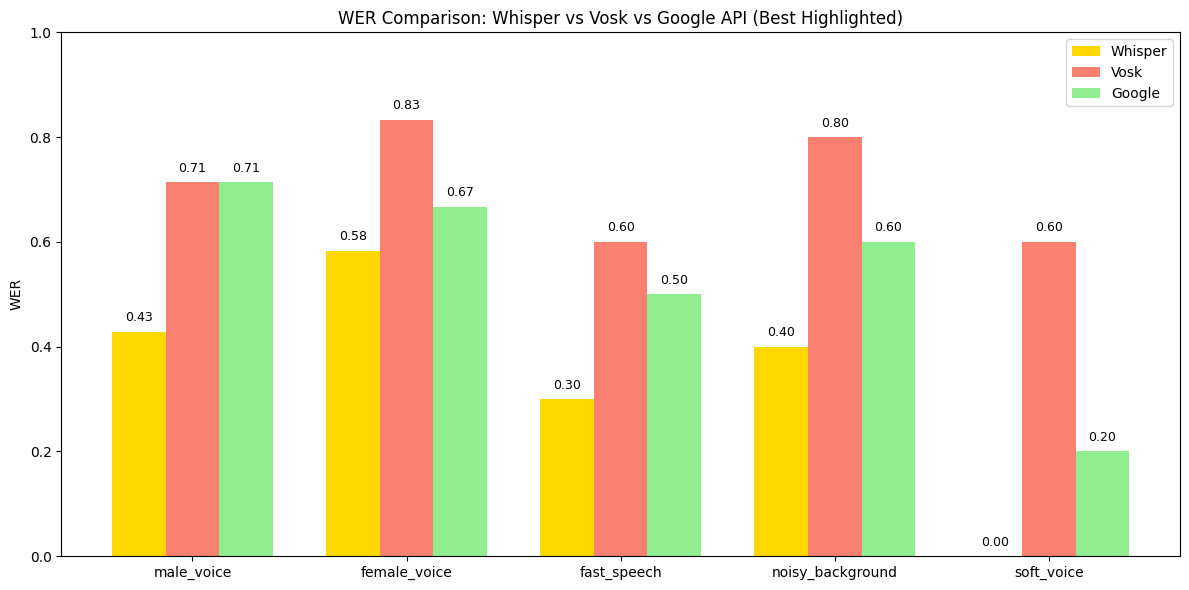

In [22]:

labels = df['File'].tolist()
whisper_wer = df['WER Whisper'].tolist()
vosk_wer = df['WER Vosk'].tolist()
google_wer = df['WER Google'].tolist()
x = range(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))

def get_color(val, min_val):
    return 'gold' if val == min_val else None

for i in range(len(labels)):
    min_wer = min(whisper_wer[i], vosk_wer[i], google_wer[i])

    ax.bar(i - width, whisper_wer[i], width=width, label='Whisper' if i==0 else "",
           color=get_color(whisper_wer[i], min_wer) or 'skyblue')
    ax.bar(i, vosk_wer[i], width=width, label='Vosk' if i==0 else "",
           color=get_color(vosk_wer[i], min_wer) or 'salmon')
    ax.bar(i + width, google_wer[i], width=width, label='Google' if i==0 else "",
           color=get_color(google_wer[i], min_wer) or 'lightgreen')

    ax.text(i - width, whisper_wer[i]+0.02, f"{whisper_wer[i]:.2f}", ha='center', fontsize=9)
    ax.text(i, vosk_wer[i]+0.02, f"{vosk_wer[i]:.2f}", ha='center', fontsize=9)
    ax.text(i + width, google_wer[i]+0.02, f"{google_wer[i]:.2f}", ha='center', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("WER")
ax.set_title("WER Comparison: Whisper vs Vosk vs Google API (Best Highlighted)")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

# Conclusion & Insights

## Conclusion

In this lab, we explored the performance of three different speech-to-text systems—**Whisper**, **Vosk**, and **Google Speech-to-Text API**—across various audio samples with distinct characteristics, such as male/female voices, fast speech, soft speech, and noisy backgrounds. The key takeaways are:

1. **Whisper** provided consistently accurate transcriptions across most samples, handling variations in voice tone and speed effectively. Its WER values were generally lower than the other two systems.
2. **Vosk**, while lightweight and offline-capable, struggled with certain audio samples, particularly those with background noise or very fast speech. Preprocessing the audio to 16 kHz mono PCM format significantly improved its performance.
3. **Google Speech-to-Text API** performed well on clear audio but occasionally failed to capture words in fast or noisy recordings. Its WER values were moderate, indicating reliable but slightly less robust performance compared to Whisper.
4. **WER Analysis** showed that Whisper frequently achieved the lowest WER across different voice types, highlighting its robustness and accuracy. Vosk and Google API had variable performance depending on audio clarity and speed.

## Insights

- **Audio Preprocessing is Crucial**: Normalizing sample rate and channels (16 kHz mono) is essential, especially for Vosk and Google APIs.
- **System Selection Depends on Use Case**:
  - **Whisper**: Best for high-accuracy offline transcription.
  - **Vosk**: Lightweight, offline, but needs careful preprocessing.
  - **Google API**: Easy-to-use cloud service, moderate accuracy, requires internet.
- **Noise and Speech Rate Impact Accuracy**: Fast speech and noisy backgrounds increase WER for all systems, but Whisper shows better resilience.
- **Evaluation Using WER**: Word Error Rate provides a quantitative measure to compare transcription quality across systems.
- **Hybrid Approaches**: Combining multiple systems or using post-processing could further improve transcription accuracy.

**Overall**, this lab demonstrates the strengths and limitations of different speech recognition technologies and emphasizes the importance of preprocessing, system choice, and evaluation metrics like WER for practical applications.

